In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps
from census import Census
from config import gkey,census_key

In [2]:
fire_data_df = pd.read_csv("Fire_Data.csv",low_memory=False)
fire_data_df.head()

,FPA_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DOY,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,STAT_CAUSE_DESCR,OWNER_CODE,OWNER_DESCR,DAYS_TO_CONT,__DISCOVERY_DATE,__CONT_DATE
0,FS-1418826,FOUNTAIN,2005,33,33.0,0.10,A,40.036944,-121.005833,CA,63,Miscellaneous,5.0,USFS,0.0,2005-02-02,2005-02-02
1,FS-1418827,PIGEON,2004,133,133.0,0.25,A,38.933056,-120.404444,CA,61,Lightning,5.0,USFS,0.0,2004-05-12,2004-05-12
2,FS-1418835,SLACK,2004,152,152.0,0.10,A,38.984167,-120.735556,CA,17,Debris Burning,13.0,STATE OR PRIVATE,0.0,2004-05-31,2004-05-31
3,FS-1418845,DEER,2004,180,185.0,0.10,A,38.559167,-119.913333,CA,3,Lightning,5.0,USFS,5.0,2004-06-28,2004-07-03
4,FS-1418847,STEVENOT,2004,180,185.0,0.10,A,38.559167,-119.933056,CA,3,Lightning,5.0,USFS,5.0,2004-06-28,2004-07-03


In [ ]:
fire_data_np = np.load("Fire_Data.npy",allow_pickle=True)
fire_data_np

In [3]:
yr_state_grp = fire_data_df.groupby(["FIRE_YEAR","STATE"])
avg_fire_size_df = pd.DataFrame(yr_state_grp.FIRE_SIZE.mean()).reset_index()
sum_fire_size_df = pd.DataFrame(yr_state_grp.FIRE_SIZE.sum()).reset_index()

In [5]:
# scatter plot top 4 states x=DOY(disc and cont) y=fire_size color=((blue=disc),(red=cont))

In [6]:
avg_fire_size_pivot = avg_fire_size_df.pivot("FIRE_YEAR","STATE").unstack(fill_value=0)
avg_fire_size_pivot.FIRE_SIZE

STATE  FIRE_YEAR
AK     1992         296.709771
       1993         798.131823
       1994         409.320156
       1995         105.172488
       1996         833.979387
                       ...    
WY     2011         210.672781
       2012         461.095086
       2013          93.497074
       2014          12.984689
       2015          58.261432
Length: 1248, dtype: float64

In [7]:
years = np.arange(fire_data_df.FIRE_YEAR.min(),fire_data_df.FIRE_YEAR.max()+1)
years

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015], dtype=int64)

In [8]:
ca_avg_fire_size = avg_fire_size_pivot.loc[:,["CA"]]
ga_avg_fire_size = avg_fire_size_pivot.loc[:,["GA"]]
tx_avg_fire_size = avg_fire_size_pivot.loc[:,["TX"]]
nc_avg_fire_size = avg_fire_size_pivot.loc[:,["NC"]]

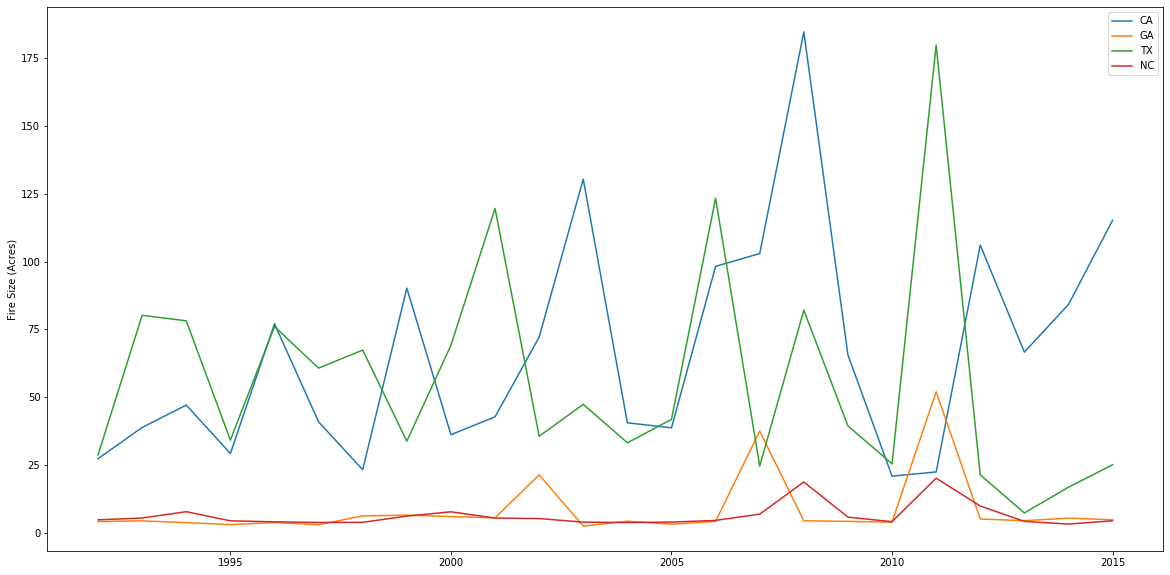

In [9]:
plt.figure(figsize=(20,10))
ca, = plt.plot(years,ca_avg_fire_size,label="CA")
ga, = plt.plot(years,ga_avg_fire_size,label="GA")
tx, = plt.plot(years,tx_avg_fire_size,label="TX")
nc, = plt.plot(years,nc_avg_fire_size,label="NC")
plt.legend(handles=[ca,ga,tx,nc])
plt.ylabel("Fire Size (Acres)")
plt.show()

In [10]:
fire_data_df.STAT_CAUSE_DESCR.value_counts()

Debris Burning       429028
Miscellaneous        323805
Arson                281455
Lightning            278468
Missing/Undefined    166723
Equipment Use        147612
Campfire              76139
Children              61167
Smoking               52869
Railroad              33455
Powerline             14448
Fireworks             11500
Structure              3796
Name: STAT_CAUSE_DESCR, dtype: int64

In [11]:
ca_fire_cause = fire_data_df[fire_data_df["STATE"] == "CA"]["STAT_CAUSE_DESCR"].value_counts()
ga_fire_cause = fire_data_df[fire_data_df["STATE"] == "GA"]["STAT_CAUSE_DESCR"].value_counts()
tx_fire_cause = fire_data_df[fire_data_df["STATE"] == "TX"]["STAT_CAUSE_DESCR"].value_counts()
nc_fire_cause = fire_data_df[fire_data_df["STATE"] == "NC"]["STAT_CAUSE_DESCR"].value_counts()

In [12]:
ca_fire_size = fire_data_df[fire_data_df["STATE"] == "CA"]["FIRE_SIZE"]
ga_fire_size = fire_data_df[fire_data_df["STATE"] == "GA"]["FIRE_SIZE"]
tx_fire_size = fire_data_df[fire_data_df["STATE"] == "TX"]["FIRE_SIZE"]
nc_fire_size = fire_data_df[fire_data_df["STATE"] == "NC"]["FIRE_SIZE"]

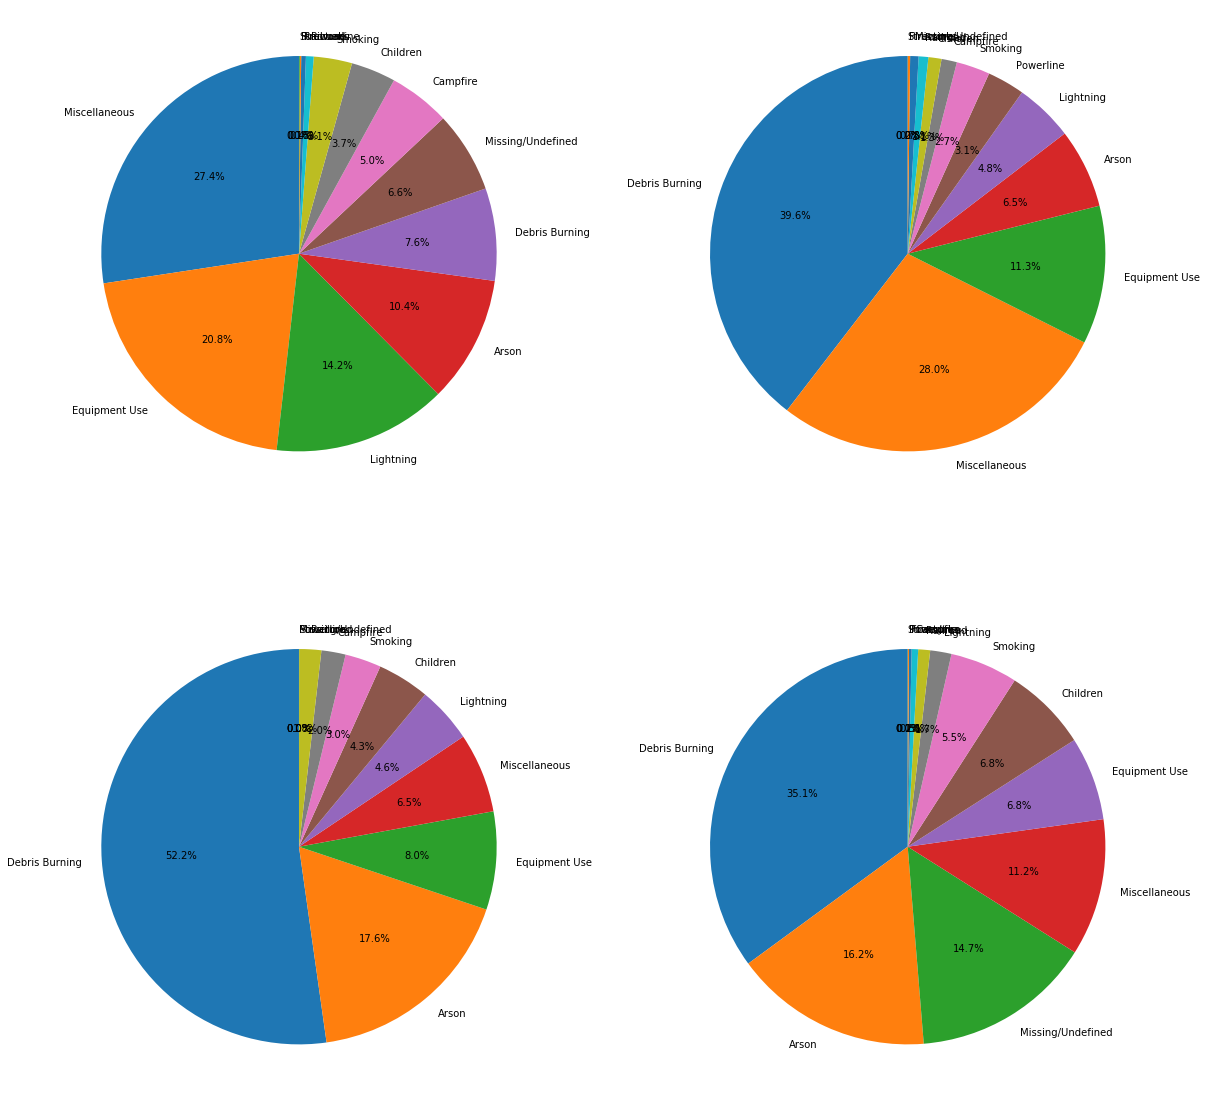

In [13]:
fig, axs = plt.subplots(2, 2,figsize=(20,20))
ax1 = axs[0, 0]
ax1.pie(ca_fire_cause, labels=ca_fire_cause.index.values, autopct="%1.1f%%", startangle=90)
ax3 = axs[1, 0]
ax3.pie(ga_fire_cause, labels=ga_fire_cause.index.values, autopct="%1.1f%%", startangle=90)
ax2 = axs[0, 1]
ax2.pie(tx_fire_cause, labels=tx_fire_cause.index.values, autopct="%1.1f%%", startangle=90)
ax4 = axs[1, 1]
ax4.pie(nc_fire_cause, labels=nc_fire_cause.index.values, autopct="%1.1f%%", startangle=90)
fig.savefig("Pie_charts_cause.png")
plt.show()

In [4]:
# scatter plot top 4 states x=disc_doy y=fire_size mask=days_to_cont 

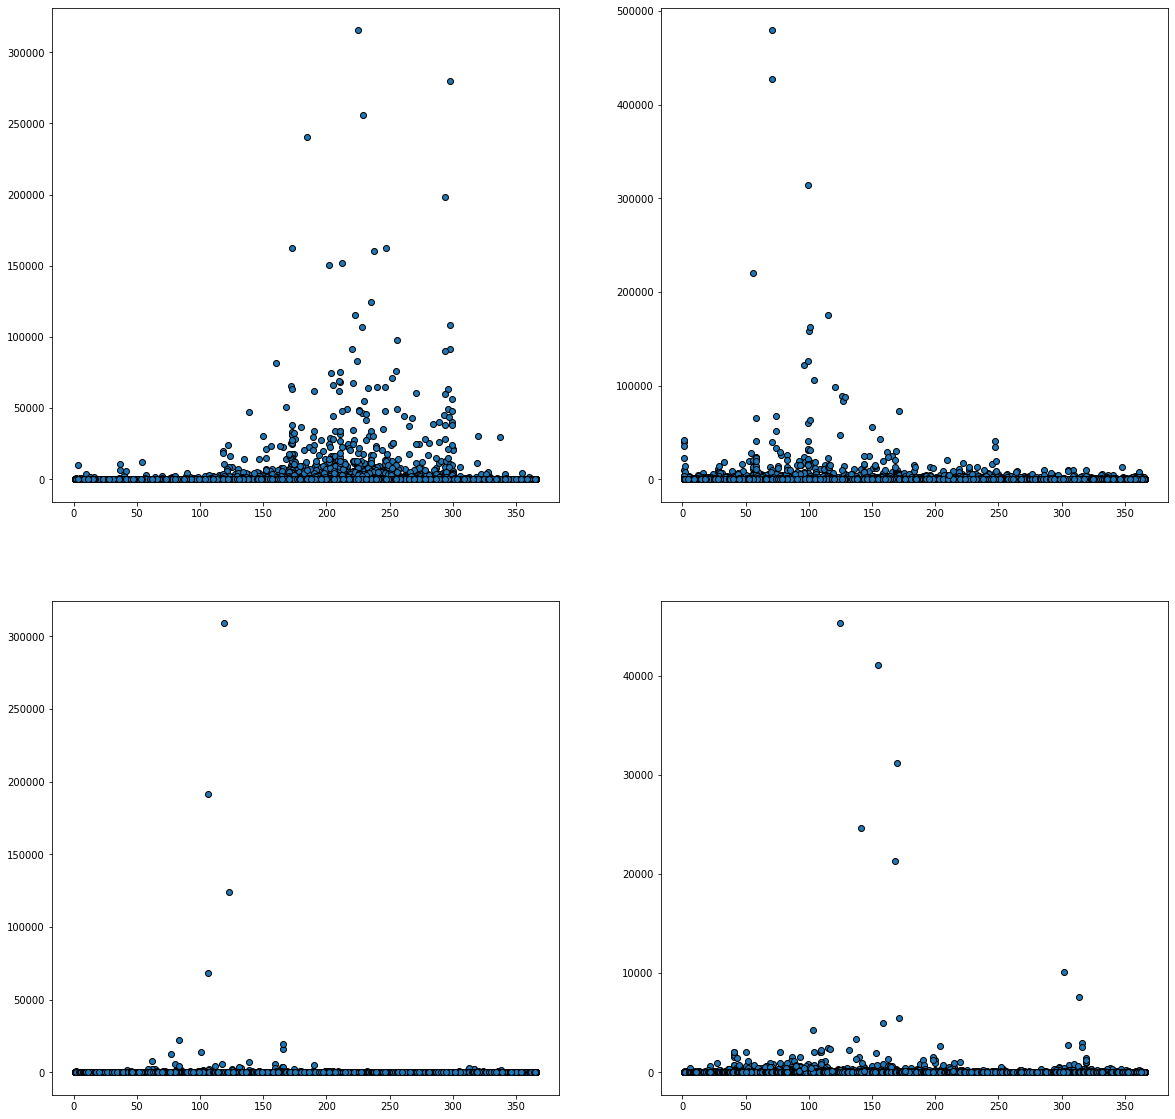

In [17]:
fig, axs = plt.subplots(2, 2,figsize=(20,20))
ax1 = axs[0, 0]
ax1.scatter((fire_data_df[fire_data_df["STATE"] == "CA"]["DISCOVERY_DOY"]), ca_fire_size,edgecolors='k')
ax3 = axs[1, 0]
ax3.scatter((fire_data_df[fire_data_df["STATE"] == "GA"]["DISCOVERY_DOY"]), ga_fire_size,edgecolors='k')
ax2 = axs[0, 1]
ax2.scatter((fire_data_df[fire_data_df["STATE"] == "TX"]["DISCOVERY_DOY"]), tx_fire_size,edgecolors='k')
ax4 = axs[1, 1]
ax4.scatter((fire_data_df[fire_data_df["STATE"] == "NC"]["DISCOVERY_DOY"]), nc_fire_size,edgecolors='k')
fig.savefig("Pie_charts_cause.png")
plt.show()

In [ ]:
fire_data_df.FIRE_SIZE_CLASS.value_counts()

In [23]:
fire_size_1992 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1992]["FIRE_SIZE"].astype(float)
fire_loca_1992 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1992][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1993 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1993]["FIRE_SIZE"].astype(float)
fire_loca_1993 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1993][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1994 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1994]["FIRE_SIZE"].astype(float)
fire_loca_1994 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1994][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1995 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1995]["FIRE_SIZE"].astype(float)
fire_loca_1995 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1995][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1996 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1996]["FIRE_SIZE"].astype(float)
fire_loca_1996 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1996][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1997 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1997]["FIRE_SIZE"].astype(float)
fire_loca_1997 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1997][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1998 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1998]["FIRE_SIZE"].astype(float)
fire_loca_1998 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1998][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_1999 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1999]["FIRE_SIZE"].astype(float)
fire_loca_1999 = fire_data_df[fire_data_df["FIRE_YEAR"] == 1999][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2000 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2000]["FIRE_SIZE"].astype(float)
fire_loca_2000 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2000][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2001 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2001]["FIRE_SIZE"].astype(float)
fire_loca_2001 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2001][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2002 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2002]["FIRE_SIZE"].astype(float)
fire_loca_2002 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2002][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2003 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2003]["FIRE_SIZE"].astype(float)
fire_loca_2003 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2003][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2004 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2004]["FIRE_SIZE"].astype(float)
fire_loca_2004 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2004][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2005 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2005]["FIRE_SIZE"].astype(float)
fire_loca_2005 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2005][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2006 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2006]["FIRE_SIZE"].astype(float)
fire_loca_2006 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2006][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2007 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2007]["FIRE_SIZE"].astype(float)
fire_loca_2007 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2007][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2008 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2008]["FIRE_SIZE"].astype(float)
fire_loca_2008 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2008][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2009 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2009]["FIRE_SIZE"].astype(float)
fire_loca_2009 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2009][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2010 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2010]["FIRE_SIZE"].astype(float)
fire_loca_2010 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2010][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2011 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2011]["FIRE_SIZE"].astype(float)
fire_loca_2011 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2011][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2012 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2012]["FIRE_SIZE"].astype(float)
fire_loca_2012 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2012][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2013 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2013]["FIRE_SIZE"].astype(float)
fire_loca_2013 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2013][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2014 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2014]["FIRE_SIZE"].astype(float)
fire_loca_2014 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2014][["LATITUDE", "LONGITUDE"]].astype(float)
fire_size_2015 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2015]["FIRE_SIZE"].astype(float)
fire_loca_2015 = fire_data_df[fire_data_df["FIRE_YEAR"] == 2015][["LATITUDE", "LONGITUDE"]].astype(float)

In [25]:
fire_loca_2005.head()

,LATITUDE,LONGITUDE
0,40.036944,-121.005833
7,40.968056,-122.433889
8,41.233611,-122.283333
31,43.995556,-121.414167
35,44.043333,-121.386111


In [26]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [ ]:
# Store locations 
fire_locations = fire_data_df[["LATITUDE", "LONGITUDE"]].astype(float)
# Convert to float and store
fire_size = fire_data_df["FIRE_SIZE"].astype(float)

In [ ]:
# Create a Heatmap layer
fig = gmaps.figure(map_type="TERRAIN")

In [ ]:
fire_layer = gmaps.heatmap_layer(fire_locations, weights=fire_size, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = .05)

In [ ]:
fig.add_layer(fire_layer)

fig

In [32]:
from IPython.display import display
import ipywidgets as widgets

class Fire_Data_Explorer(object):
    """
    Jupyter widget for exploring the dataset.

    The user uses the slider to choose a year. This renders
    a heatmap of wildfires in that year.
    """

    def __init__(self, df):
        self._df = df
        self._heatmap = None
        self._slider = None
        initial_year = min(self._df['FIRE_YEAR'])

        title_widget = widgets.HTML(
            '<h3>Wildfires in the United States (1992-2015), by year</h3>'
            '<h4>Data from <a href="https://www.fs.usda.gov/rds/archive/catalog/RDS-2013-0009.4 ">Forest Service Research Data Archive</a></h4>'
        )

        map_figure = self._render_map(initial_year)
        controls = self._render_controls(initial_year)
        self._container = widgets.VBox([title_widget, controls, map_figure])

    def render(self):
        display(self._container)

    def _on_year_change(self, change):
        year = self._slider.value
        self._heatmap.locations = self._locations_for_year(year)
        self._total_box.value = self._total_fires_text_for_year(year)
        return self._container

    def _render_map(self, initial_year):
        fig = gmaps.figure(map_type='TERRAIN')
        self._heatmap = gmaps.heatmap_layer(
            self._locations_for_year(initial_year),
            max_intensity=100,
            point_radius=5
        )
        fig.add_layer(self._heatmap)
        return fig

    def _render_controls(self, initial_year):
        self._slider = widgets.IntSlider(
            value=initial_year,
            min=min(self._df['FIRE_YEAR']),
            max=max(self._df['FIRE_YEAR']),
            description='Year',
            continuous_update=False
        )
        self._total_box = widgets.Label(
            value=self._total_fires_text_for_year(initial_year)
        )
        self._slider.observe(self._on_year_change, names='value')
        controls = widgets.HBox(
            [self._slider, self._total_box],
            layout={'justify_content': 'space-between'}
        )
        return controls

    def _locations_for_year(self, year):
        return self._df[self._df['FIRE_YEAR'] == year][['LATITUDE', 'LONGITUDE']]

    def _total_fires_for_year(self, year):
        return int(self._df[self._df['FIRE_YEAR'] == year]['FIRE_YEAR'].count())

    def _total_fires_text_for_year(self, year):
        return '{} wildfires'.format(self._total_fires_for_year(year))


Fire_Data_Explorer(fire_data_df).render()